In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Read and downsize dataset to reduce computation
dataframe = pd.read_csv("./credit_card_dataset.csv")
dataframe = dataframe.sample(120000, random_state=1234)
dataframe.head(10)

# dataframe_features = dataframe.drop(columns="Class")
# feature_size = len(dataframe.columns)-1
# raw_data = dataframe_features.values
# normal_dataframe = dataframe[dataframe["Class"]==0]
# outliers_dataframe = dataframe[dataframe["Class"]==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
268473,163229.0,2.169047,-0.756368,-1.445401,-0.986344,-0.328126,-0.803458,-0.307965,-0.227503,-0.706145,...,0.068633,0.183689,0.136915,-0.386586,-0.020652,-0.274007,-0.043749,-0.075371,23.83,0
257433,158160.0,1.731118,-1.298628,-1.371029,-0.565997,-0.835963,-0.530364,-0.673352,-0.101704,-0.305651,...,0.399696,0.793541,-0.132938,-0.404085,-0.186849,-0.111361,-0.008336,0.011739,219.00,0
251728,155474.0,2.061410,-0.042092,-1.058692,0.417580,-0.138151,-1.216273,0.193005,-0.342222,0.523362,...,-0.287237,-0.688060,0.339764,0.049491,-0.295723,0.194975,-0.069999,-0.059566,1.98,0
129621,79159.0,-1.180349,1.235032,1.216749,0.992465,0.010314,-0.204204,0.562175,0.509803,-1.347151,...,-0.336775,-1.258057,0.094664,-0.073791,0.162540,-0.637179,0.175878,0.044700,64.95,0
216205,140383.0,0.152871,-0.443881,0.491094,-1.883131,-0.006171,-0.492830,0.392772,-0.292055,-0.547976,...,0.352442,1.031532,0.209234,0.737304,-1.167852,-0.453702,0.069483,0.051294,69.00,0
112347,72619.0,0.211224,-1.949943,0.582035,0.760730,-1.484415,0.297385,-0.079429,0.080544,1.093917,...,0.091308,-0.571440,-0.321570,0.178417,-0.118088,0.887856,-0.108949,0.097274,500.64,0
40369,40211.0,1.080521,-1.735896,0.891142,-1.233294,-2.176076,-0.459112,-1.220203,0.006537,-1.781381,...,-0.025117,-0.136486,-0.035782,0.517567,0.033519,-0.310973,0.020989,0.055870,192.55,0
283876,171943.0,2.067472,0.182315,-1.769981,0.504935,0.191285,-1.451350,0.244282,-0.364248,0.661711,...,0.181263,0.681636,-0.033831,-0.185024,0.259475,-0.092967,-0.005152,-0.033476,3.41,0
165925,117752.0,1.951849,-0.421154,-0.568300,0.306642,-0.411409,-0.191401,-0.546755,0.005601,1.236819,...,0.223792,0.736913,0.143486,0.619821,-0.127005,-0.270497,0.027681,-0.026081,34.33,0
132749,80097.0,-1.190729,1.424424,0.769237,-0.368968,-0.018032,0.045970,0.135975,0.470975,-0.558542,...,0.115792,0.109785,-0.074027,-0.267121,-0.077192,0.350483,-0.432492,0.002225,4.99,0


In [3]:
# Select the top n features
data_norm = MinMaxScaler().fit_transform(dataframe.values)

n = 10
selector = SelectKBest(chi2, k=n)
data_new = selector.fit_transform(data_norm, dataframe["Class"])

feature_support = selector.get_support()
selected_features = dataframe.loc[:,feature_support].columns

# Prepare transformed dataset with reduced features as dataframe
reduced_df = pd.DataFrame(data = data_new, columns = selected_features)

In [4]:
# Prepare dataset for autoencoder
raw_data = reduced_df.values
feature_size = len(selected_features)-1

# The last column contains the labels
labels = raw_data[:, -1]

# The other columns consist of selected features
data = raw_data[:, 0:-1]

In [5]:
# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=7)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
# Differentiate between normal and anomalous datasets
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [7]:
# Define an anomaly detector model as an autoencoder
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(feature_size, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [8]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='MAE')

In [9]:
# Train the autoencoder on the normal dataset
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=32,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/20
2995/2995 [==============================] - 8s 2ms/step - loss: 0.0360 - val_loss: 0.0201
Epoch 2/20
2995/2995 [==============================] - 5s 2ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 3/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 4/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 5/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 6/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 7/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0121
Epoch 8/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 9/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 10/20
2995/2995 [==============================] - 5s 2ms/step - loss: 0.011

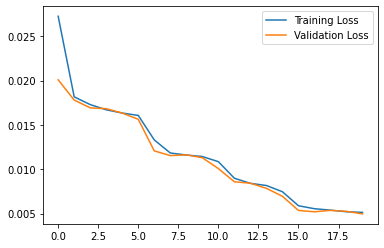

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [11]:
# Compute reconstruction error of normal test data
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.MAE(reconstructions, normal_test_data)

In [12]:
# Initial ansatz for threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.009312739


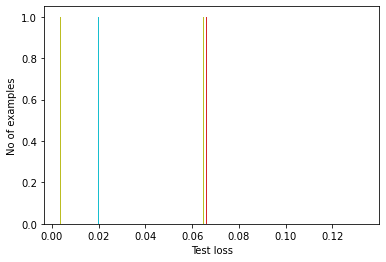

In [13]:
# Compute reconstruction error of anomalous test data
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.MAE(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.MAE(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [15]:
# Evaluate performance
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.08325
Precision = 0.00031851481093870865
Recall = 0.1794871794871795


In [16]:
# Evaluate performance based on a different threshold
preds = predict(autoencoder, test_data, threshold/10)
print_stats(preds, test_labels)

Accuracy = 0.9975416666666667
Precision = 0.0
Recall = 0.0


In [17]:
# Select the top two features for visualization

feature_size = len(dataframe.columns)-1
outliers_df = dataframe[dataframe["Class"]==1]

X1 = dataframe[selected_features[0]]
X2 = dataframe[selected_features[1]]

Y1 = outliers_df[selected_features[0]]
Y2 = outliers_df[selected_features[1]]

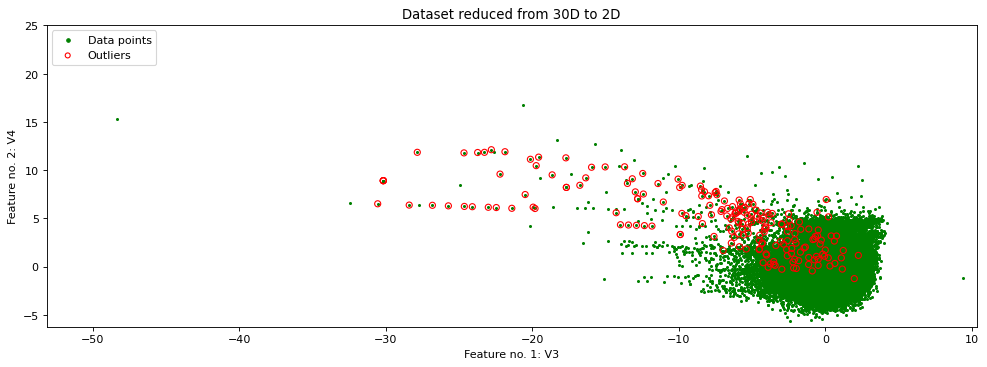

In [18]:
# Plot all data points according to the top two selected features

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dataset reduced from " + str(feature_size) + "D to 2D")
plt.scatter(X1, X2, 
            color="g", 
            s=3, 
            label="Data points")

# Plot red circles around outliers in the dataset according to ground truth

plt.scatter(Y1, Y2, 
            s=30,
            edgecolors="r",
            facecolors="none", 
            label="Outliers")
plt.axis("tight")
plt.xlim((1.1*min(X1), 1.1*max(X1)))
plt.xlabel("Feature no. 1: " + selected_features[0])
plt.ylim((1.1*min(X2), 1.5*max(X2)))
plt.ylabel("Feature no. 2: " + selected_features[1])
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

The data points that are within the dense cluster and yet marked as outliers are possibly outliers along some other dimensions. We have plotted the data points according to the top two most relevant features.